## Advanced Lane Finding
[![Udacity - Self-Driving Car NanoDegree](https://s3.amazonaws.com/udacity-sdc/github/shield-carnd.svg)](http://www.udacity.com/drive)


In this project, your goal is to write a software pipeline to identify the lane boundaries in a video, but the main output or product we want you to create is a detailed writeup of the project.  Check out the [writeup template](https://github.com/udacity/CarND-Advanced-Lane-Lines/blob/master/writeup_template.md) for this project and use it as a starting point for creating your own writeup.  

Creating a great writeup:
---
A great writeup should include the rubric points as well as your description of how you addressed each point.  You should include a detailed description of the code used in each step (with line-number references and code snippets where necessary), and links to other supporting documents or external references.  You should include images in your writeup to demonstrate how your code works with examples.  

All that said, please be concise!  We're not looking for you to write a book here, just a brief description of how you passed each rubric point, and references to the relevant code :). 

You're not required to use markdown for your writeup.  If you use another method please just submit a pdf of your writeup.

The Project
---

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

The images for camera calibration are stored in the folder called `camera_cal`.  The images in `test_images` are for testing your pipeline on single frames.  If you want to extract more test images from the videos, you can simply use an image writing method like `cv2.imwrite()`, i.e., you can read the video in frame by frame as usual, and for frames you want to save for later you can write to an image file.  

To help the reviewer examine your work, please save examples of the output from each stage of your pipeline in the folder called `ouput_images`, and include a description in your writeup for the project of what each image shows.    The video called `project_video.mp4` is the video your pipeline should work well on.  

The `challenge_video.mp4` video is an extra (and optional) challenge for you if you want to test your pipeline under somewhat trickier conditions.  The `harder_challenge.mp4` video is another optional challenge and is brutal!

If you're feeling ambitious (again, totally optional though), don't stop there!  We encourage you to go out and take video of your own, calibrate your camera and show us how you would implement this project from scratch!


## Import packages and define useful functions

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


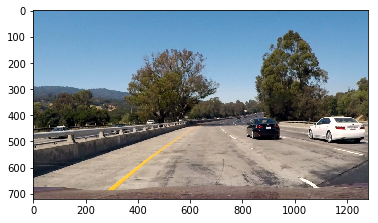

In [3]:
#reading in an image
image = mpimg.imread('test_images/test1.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [4]:
import math, sys


def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
#     return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def median_blur(img, kernel_size):
    """Applies median blurring"""
    return cv2.medianBlur(img, kernel_size)

def bilateral_blur(img, d, sigmaColor, sigmaSpace ):
    """Applies bilateral filter for image smoothing"""
    return cv2.bilateralFilter(img,d,sigmaColor,sigmaSpace)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


# ancillary functions for draw_lines
def initialize_buffers():
    """ Initialize the buffers which are global variables as empty arrays"""
    global x_rightLane, x_leftLane, y_rightLane, y_leftLane
    
    x_rightLane = []  # collection of x values for the right lane
    x_leftLane = []  # collection of x values for the left lane
    y_rightLane = []  # collection of y values for the right lane
    y_leftLane = []  # collection of y values for the left lane
    return


def update_buffers(x_buffer, y_buffer, x1, x2, y1, y2):
    """ Save new values of X's and Y's in the buffer arrays"""
    if len(x_buffer) <= 100:
        x_buffer.append(x1)
        x_buffer.append(x2)
        y_buffer.append(y1)
        y_buffer.append(y2)
    else:
        # replace the oldest values
        x_buffer[0] = x1
        x_buffer[1] = x2
        y_buffer[0] = y1
        y_buffer[1] = y2
        # rotate the data location so that the latest will be at the last index
        x_buffer = np.roll(x_buffer, -2)
        y_buffer = np.roll(y_buffer, -2)
    
    return x_buffer, y_buffer


def extrapolate_line(x_buffer, y_buffer, img, color, thickness):
    """ Extrapolate and draw a line that fits the coordinates defined by X's and Y's in the buffers"""
    imshape = img.shape  
    w1 = np.polyfit((y_buffer), (x_buffer), 1)
    y_series = np.linspace(imshape[0]*0.63, imshape[0], imshape[0]*0.4)
    fcn = np.poly1d(w1)
    x_series = fcn(y_series)
    for i in range(1,len(y_series)):
        cv2.line(img,(int(x_series[i-1]),int(y_series[i-1])), (int(x_series[i]),int(y_series[i])), color, thickness)
    return


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    imshape = img.shape  
    global x_rightLane, x_leftLane, y_rightLane, y_leftLane
    
    # save X's and Y's into the buffers
    try:
        for line in lines:
            for x1,y1,x2,y2 in line:
                slope = round((y2-y1)/((x2-x1)+1e-100), 3) * 180/ math.pi  # slope in degree units
                
                if -30 < slope < 30: # filter out lines with slope that are close to horizontal
                    pass
                else:
#                     cv2.line(img,(x1,y1), (x2,y2), color, thickness)  # to display original detected lines
                    # segregate points belonging to the left lane and right lane based on x values
                    if (imshape[1]*0.1 < x1 < imshape[1]*0.5) or (imshape[1]*0.1 < x2 < imshape[1]*0.5): 
                        x_leftLane, y_leftLane = update_buffers(x_leftLane, y_leftLane, x1,x2,y1,y2)    
                        
                    elif (imshape[1]*0.5 < x1 <imshape[1]*0.9) or (imshape[1]*0.5 < x2 <imshape[1]*0.9):
                        x_rightLane, y_rightLane = update_buffers(x_rightLane, y_rightLane, x1,x2,y1,y2)
                    else:
                        pass
    except NameError:
        # first frame is empty
        initialize_buffers()     
    except:
        print('Error: ', sys.exc_info()[1])
    
    # extrapolate  and draw lane lines
    try:
        extrapolate_line(x_leftLane, y_leftLane, img, color, thickness)  # fit line for the left lane
        extrapolate_line(x_rightLane, y_rightLane, img, color, thickness)  # fit a line for the right lane
        
#           print(len(x_leftLane), len(x_rightLane))  # to check how many points approximately are detected in each video frame 
    except NameError:
        # first frame is empty
        initialize_buffers()        
    except TypeError:
        pass
    except:
        print('Error: ', sys.exc_info()[1])
        
    return
        
 
              
        
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

### Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
    

In [ ]:
def calibrate_cam():
    """ Compute the camera calibration matrix """
    return M

def get_distortion_coefficient():
    """ Compute the distortion coefficients"""
    return dist



### Apply a distortion correction to raw images.
    

In [ ]:
def correct_distortion(img):
    """Correct the distortion in raw images"""
    return dst

### Use color transforms, gradients, etc., to create a thresholded binary image.
    

### Apply a perspective transform to rectify binary image ("birds-eye view").
    

### Detect lane pixels and fit to find the lane boundary.
    

### Determine the curvature of the lane and vehicle position with respect to center.
    

### Warp the detected lane boundaries back onto the original image.
    

### Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
 

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [5]:
import os
os.listdir("test_images/")

['solidYellowLeft.jpg',
 'new_solidWhiteCurve.jpg',
 'new_solidYellowCurve.jpg',
 'new_solidWhiteRight.jpg',
 'new_solidYellowCurve2.jpg',
 'new_solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidWhiteRight.jpg',
 'new_whiteCarLaneSwitch.jpg',
 'solidYellowCurve2.jpg',
 'solidWhiteCurve.jpg',
 'solidYellowCurve.jpg']

run your solution on all test_images and make copies into the test_images directory).

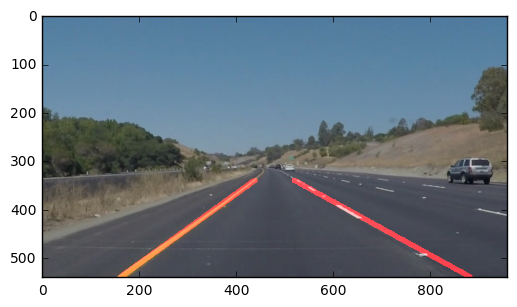

In [6]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

# get list of images to be processed
imageList = ['solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve2.jpg',
 'solidWhiteCurve.jpg',
 'solidYellowCurve.jpg']



for imageName in imageList:
    # read in image
    img = mpimg.imread('test_images/'+imageName)
   
    # set global variables
    x_rightLane = []  # collection of x values for the right lane
    x_leftLane = []  # collection of x values for the left lane
    y_rightLane = []  # collection of y values for the right lane
    y_leftLane = []  # collection of y values for the left lane

    # blur image
    d = 5  # Diameter of each pixel neighborhood that is used during filtering
    sigmaColor = 100  # pixel distance in color space that will be mixed together
    sigmaSpace = 100  # pixel distance in coordinate space that will affect each other
    img_blur = bilateral_blur(img,d,sigmaColor,sigmaSpace)
    
    
    # detect edges
    low_threshold = 50
    high_threshold = 150
    img_edges = canny(img_blur, low_threshold, high_threshold)

    imshape = img.shape
    total_pixels = imshape[0]*imshape[1]
    vertices = np.array([[(imshape[1]*0.15,imshape[0]*0.9), (imshape[1]*0.4, imshape[0]*0.67), (imshape[1]*0.6, imshape[0]*0.67), (imshape[1]*0.85,imshape[0]*0.9)]], dtype=np.int32)
    masked_edges = region_of_interest(img_edges, vertices)
    
    # define Hough transform parameters
    rho = 1           # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 30    # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 100  # minimum number of pixels making up a line
    max_line_gap = 160  # maximum gap in pixels between connectable line segments
    lines = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)
    weighted_image = weighted_img(lines, img, α=0.8, β=1., λ=0.)
    plt.imshow(weighted_image)

    # convert image to RGB and save image
    output_image = cv2.cvtColor(weighted_image, cv2.COLOR_BGR2RGB)
    newName = 'test_images/new_'+imageName
    cv2.imwrite(newName, output_image)



## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [7]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    
 
    # blur image
    d = 5  # Diameter of each pixel neighborhood that is used during filtering
    sigmaColor = 100  # pixel distance in color space that will be mixed together
    sigmaSpace = 100  # pixel distance in coordinate space that will affect each other
    img_blur = bilateral_blur(image,d,sigmaColor,sigmaSpace)
    
    # detect edges
    low_threshold = 50
    high_threshold = 150
    img_edges = canny(img_blur, low_threshold, high_threshold)

    imshape = image.shape
    total_pixels = imshape[0]*imshape[1]
    vertices = np.array([[(imshape[1]*0.15,imshape[0]*0.9), (imshape[1]*0.4, imshape[0]*0.67), (imshape[1]*0.6, imshape[0]*0.67), (imshape[1]*0.85,imshape[0]*0.9)]], dtype=np.int32)
    masked_edges = region_of_interest(img_edges, vertices)
    
    # define Hough transform parameters
    rho = 1           # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 30    # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 100  # minimum number of pixels making up a line
    max_line_gap = 160  # maximum gap in pixels between connectable line segments
    lines = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)
    weighted_image = weighted_img(lines, image, α=0.8, β=1., λ=0.)
  
    result = weighted_image
    return result

Let's try the one with the solid white lane on the right first ...

In [8]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")

# reset global variables so that the previous videos won't have an effect on the current video
# this segment can be deleted in actual application of this code, i.e., realtime lane detection
try:  # if global variables already exist, delete it
    del x_rightLane, x_leftLane, y_rightLane, y_leftLane
except: # otherwise, do nothing
    pass


white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

    
    

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:20<00:00, 11.91it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 52.6 s, sys: 1.37 s, total: 53.9 s
Wall time: 21.9 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [10]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')

# reset global variables so that the previous videos won't have an effect on the current video
# this segment can be deleted in actual application of this code, i.e., realtime lane detection
try:  # if global variables already exist, delete it
    del x_rightLane, x_leftLane, y_rightLane, y_leftLane
except: # otherwise, do nothing
    pass


yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [01:15<00:00,  9.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 3min 15s, sys: 5.24 s, total: 3min 21s
Wall time: 1min 17s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


### Algorithm Limitations
This algorithm successfully detects the lane lines in the given videos including the challenge video. However, the line segregation is based on the assumption that the left and right lanes are approximately located at the left and right side of the video frame respectively which is only true if the vehicle (or the camera) is located somewhere in the middle of the road lanes. In situations that this assumption is false, the algorithm would probably fail to segregate the detected lines properly. If line segregation fails, the lane approximation would also fail. For example, it is yet unknown how the algorithm would perform when the car meets a street intersection. 

Another limitation of this algorithm is that it only annotates straight lines, in fact, this is the reason that the annotation is shortened since it would overshoot in the curved lanes like in the challenge video.

### Room for improvements
To make the algorithm better, more stable, and generic, there should be a better way of segregating the lane lines and employ some other techniques of image pre-processing to enhance the detection of the edges. I am thinking of trying the method proposed by some colleagues in Github and Slack which is warping the image to create a "birds-eye-view" of the road. Then, different filters shall be used to detect lanes of different colors. They also use a different approach of segregating the lines into left and right lanes which is by dividing the image horizontally into several strips. They derive the histogram of the detected X's on each strip and use the top 2 as the location of the left and right lanes. I think this is a better way of line segregation. Their implementation was published for the 4th project of this program and it looks so cool. I am excited to improve this code and create something as fascinating as they did.

Another room for improvement is to use curve annotations that follow the curvature of the lane lines. Further experimentation and tweaking with the data and the 2nd degree of the numpy.polyfit() function would be a good point to start.

Lastly, it would be nice to make the algorithm know how to detect the edge of the road. This is useful in actual driving scenario when the roads has no lane lines painted on, e.g., in rural dirt roads. I am planning to use this algorithm in detecting the road edges and the lane lines here in my country, the Philippines, which is known to be one of the countries with worst traffic scenarios.  


### Hurdles and Lessons Learned
*I had a lot of fun doing this project! What puzzled me out in the beginning is that I detect too few edges. I traced the problem, trying to find out if there is something wrong with how I use the bilateral filter. I displayed the output of each step of the pipeline and I discovered that I lose the detected edges after image masking. I made a mistake in writing the order of the vertices of the polygon mask. I found out that the sequence of the vertices is crucial in creating the intended shape of the polygon. Displaying the mask helped a lot to see where the mask actualy lies on the image and on the video.*
*It is difficult to detect some colors if an image is converted to grayscale. This was observed in the challenge video when there was a portion of the road where the yellow lane would just "disappear" in grayscale. Trying to detect the yellow lane in a colored image gave a hint that it is the way to go. This also led to finding a better smoothing technique. After searching through the opencv documentation about smoothing images, I settled on using bilateral filter instead of the gausian filter. Bilateral filter is better at keeping the edges while smoothing out the noises and it gives a parameter on how distant in the color space should the pixels be for them to be combined. However, bilateral filtering increases the data processing time.*
*Before using the numpy.polyfit function, I manually get the mean of X's and Y's so I can get a reference point on the lane. To extrapolate the line, I derive two points from the reference point. The two points for X are derived by adding and subtracting the standard deviation from the reference X.*
    
    x1 = x_mean + x_std
    x2 = x_mean - x_std

Similar method is used for the Y's:
    
    y1 = y_mean + y_std
    y2 = y_mean - y_std
    
Then, I would use the opencv function to draw the extrapolated line:

    cv2.line(img,(int(x1),int(y1)),(int(x2),int(y2)), color, thickness)

However, this method requires more lines of code and is only limited to straight lines. So I had decided to use the numpy.polyfit function which can extrapolate into several polynomial degree. I did try the second degree approximation but somehow it makes the annotation lines too "snaky". Hence, in the end, I still settled on the linear approximation which I think sufficient for the requirements of this project. 
I am planning to improve the codes though to make it more generic and follow a curve line. I think this would be implemented in the project 4.

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [12]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')

# reset global variables so that the previous videos won't have an effect on the current video
# this segment can be deleted in actual application of this code, i.e., realtime lane detection
try:  # if global variables already exist, delete it
    del x_rightLane, x_leftLane, y_rightLane, y_leftLane
except: # otherwise, do nothing
    pass


challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:49<00:00,  5.22it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 1min 57s, sys: 5.55 s, total: 2min 2s
Wall time: 51.9 s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))